In [1]:
!pip install gymnasium


[notice] A new release of pip is available: 24.1.1 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import random, time
from collections import deque, namedtuple

import gymnasium as gym
import numpy as np
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
print("Num CPUs Available: ", len(tf.config.list_physical_devices('CPU')))

from tqdm.auto import tqdm

n_episodes = 1000  # play 1000 games
eps = 1.0  # exploration rate, probability of choosing random action
eps_decay = 0.9975  # eps gets multiplied by this number each epoch...
min_eps = 0.1  # ...until this minimum eps is reached
gamma = 0.95  # discount
max_memory_size = 10000  # size of the replay memory
batch_size = 16  # batch size of the neural network training
min_length = 160  # minimum length of the replay memory for training, before it reached this length, no gradient updates happen
memory_parts = [
    "state",
    "action",
    "next_state",
    "reward",
    "done",
]  # nice names for the part of replay memory, otherweise the names are 0-5


Num GPUs Available:  0
Num CPUs Available:  1


In [3]:
#from google.colab import drive
#drive.mount('/content/drive')

drive = '/content/drive'

# Learning A Model

In [4]:
Memory = namedtuple("Memory", memory_parts)  # a single entry of the memory replay


class ReplayMemory:
    def __init__(self, max_length=None):
        self.max_length = max_length
        self.memory = deque(maxlen=max_length)

    def store(self, data):
        self.memory.append(data)

    def _sample(self, k):
        return random.sample(self.memory, k)

    def structured_sample(self, k):
        batch = self._sample(k)
        result = {}
        for i, part in enumerate(memory_parts):
            result[part] = np.array([row[i] for row in batch])

        return result

    def __len__(self):
        return len(self.memory)

In [5]:
model = tf.keras.Sequential(
    [
        tf.keras.layers.Input(shape=(4,)),  # Define input shape with Input layer
        tf.keras.layers.Dense(128, activation="relu"),
        tf.keras.layers.Dense(64, activation="relu"),
        tf.keras.layers.Dense(16, activation="relu"),
        tf.keras.layers.Dense(2, activation="linear"),  # 2 actions: go left or go right
    ]
)
model.compile(
    loss=tf.keras.losses.MeanSquaredError(),
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
)

In [6]:
env = gym.make("CartPole-v1")
replay_memory = ReplayMemory(max_length=max_memory_size)

for episode in tqdm(range(n_episodes)):  # tqdm makes a nice proress bar
    state, _ = env.reset()
    done = False

    while not done:
        if random.random() < eps:
            action = env.action_space.sample()  # random action
        else:
            action = model.predict(state[np.newaxis, :], verbose=False).argmax()  # best action according to the model

        next_state, reward, done, _, _ = env.step(action)
        memory = Memory(state, action, next_state, reward, done)
        replay_memory.store(memory)

        if len(replay_memory) >= min_length:
            batch = replay_memory.structured_sample(batch_size)  # get samples from the replay memory

            target_batch = batch["reward"] + gamma * model.predict(batch["next_state"], verbose=False).max(axis=1) * (
                1 - batch["done"]
            )  # R(s, a) + γ·maxₐ N(s') if not a terminal state, otherwise R(s, a)
            targets = model.predict(batch["state"], verbose=False)
            targets[
                range(batch_size), batch["action"]
            ] = target_batch  # set the target for the action that was done and leave the outputs of other 3 actions as they are

            model.fit(batch["state"], targets, verbose=False, batch_size=batch_size)  # train for one epoch

        state = next_state
    if episode % 100 == 0:
      save_path = 'my_QmodelB_{}iterations.keras'.format(episode)
      print (save_path)
      model.save(save_path)
    eps = max(min_eps, eps * eps_decay)
save_path = 'my_QmodelB_{}iterations.keras'.format(episode)
print (save_path)
model.save(save_path)

  0%|          | 0/1000 [00:00<?, ?it/s]

my_QmodelB_0iterations.keras

my_QmodelB_100iterations.keras
my_QmodelB_200iterations.keras
my_QmodelB_300iterations.keras
my_QmodelB_400iterations.keras
my_QmodelB_500iterations.keras
my_QmodelB_600iterations.keras
my_QmodelB_700iterations.keras
my_QmodelB_800iterations.keras
my_QmodelB_900iterations.keras
my_QmodelB_999iterations.keras


In [27]:
eps_decay = 0.9975
min_eps = 0.00001
eps = 1.0
for i in range(1000):
  eps = max(min_eps, eps * eps_decay)
  if (i % 10==0):
    print (i, eps)

print(eps)

0 0.9975
10 0.972841184720621
20 0.9487919505650338
30 0.9253372283118559
40 0.9024623212601521
50 0.8801528960204993
60 0.8583949735337022
70 0.8371749203115317
80 0.8164794398939969
90 0.7962955645177996
100 0.7766106469907487
110 0.7574123527670455
120 0.7386886522184717
130 0.7204278130966384
140 0.7026183931815739
150 0.6852492331120414
160 0.668309449393098
170 0.6517884275765086
180 0.6356758156097455
190 0.6199615173494054
200 0.6046356862349768
210 0.5896887191189979
220 0.5751112502497359
230 0.5608941454026172
240 0.5470284961567343
250 0.5335056143128392
260 0.5203170264493284
270 0.5074544686128074
280 0.49490988113990647
290 0.48267540360710603
300 0.4707433699054044
310 0.45910630343674297
320 0.4477569124291788
330 0.43668808536786924
340 0.42589288653900503
350 0.4153645516839004
360 0.40509648376051655
370 0.39508224880976317
380 0.3853155719239871
390 0.375790333315123
400 0.3665005644800414
410 0.3574404444606915
420 0.34860429619669614
430 0.33998658296811235
440 0

# Test Learned Models

In [28]:
## Choose Model
version = 1
models = [(100, '1-3b0WuYzzscYMvJEvmdGK_GTsVvd2T_9'), (999, '1-iNHaTgKMTU7Fdoc-7IdRZCaGOFTQmIY')]

!pip install gdown
!gdown {models[version][1]}
save_path=f'my_QmodelB_{models[version][0]}iterations.keras'
print(save_path)


[notice] A new release of pip is available: 24.1.1 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip


my_QmodelB_999iterations.keras


c:\users\maxjo\appdata\local\programs\python\python39\lib\site-packages\gdown\download.py:33: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  soup = bs4.BeautifulSoup(line, features="html.parser")
Failed to retrieve file url:

	Cannot retrieve the public link of the file. You may need to change
	the permission to 'Anyone with the link', or have had many accesses.
	Check FAQ in https://github.com/wkentaro/gdown?tab=readme-ov-file#faq.

You may still be able to access the file from the browser:

	https://drive.google.com/uc?id=1-iNHaTgKMTU7Fdoc-7IdRZCaGOFTQmIY

but Gdown can't. Please check connections and permissions.


In [29]:
import matplotlib.pyplot as plt
import gymnasium as gym
import tensorflow as tf

from tensorflow.keras.models import load_model

model = load_model(save_path, compile=False)
model.compile(
    loss=tf.keras.losses.MeanSquaredError(),
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
)

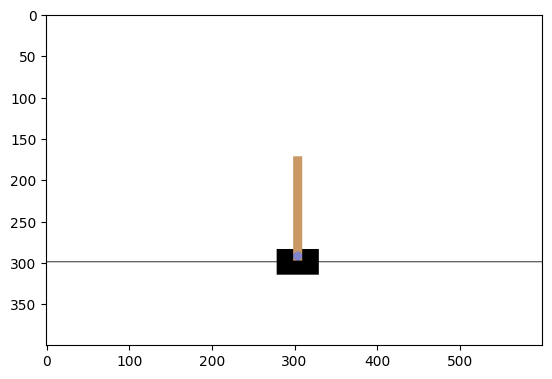

action=0, total_reward=1.0


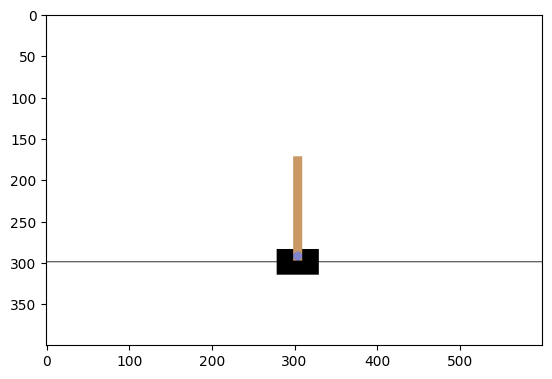

In [30]:
env = gym.make("CartPole-v1", render_mode="rgb_array")
state, _ = env.reset()
done = False
total_reward = 0
state_image=env.render()
plt.imshow(state_image)
plt.show()

state_image=env.render()
action = model.predict(state[np.newaxis, :], verbose=False).argmax(axis=1)[0]
state, reward, done, _, _ = env.step(action)
total_reward += reward
print (f"{action=}, {total_reward=}")
state_image=env.render()
plt.imshow(state_image)
plt.show()

In [31]:
env = gym.make("CartPole-v1", render_mode="human")

state, _ = env.reset()
done = False
total_reward = 0

while not done and total_reward < 500:  # force end the game after 500 time steps because the model is too good!
    env.render()
    action = model.predict(state[np.newaxis, :], verbose=False).argmax(axis=1)[0]
    state, reward, done, _, _ = env.step(action)
    total_reward += reward

env.close()
print (f"{total_reward=}")

total_reward=91.0


In [14]:
env.close()

This was the default. It worked a little bit, but it seemed more concerned about keeping it upright than keeping it in the center of the screen.